In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from itertools import cycle, islice, product
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_completeness_v_measure, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering, Birch

import warnings
warnings.filterwarnings('ignore')

выберем датасет

In [6]:
dataset = pd.read_csv('car_data.csv')
dataset.head()

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0


убедимся в отсутствии пропусков

In [7]:
dataset.isnull().sum()

User ID         0
Gender          0
Age             0
AnnualSalary    0
Purchased       0
dtype: int64

пусть значения наших колонок будет числовыми

In [8]:
le = LabelEncoder()
mms = MinMaxScaler()
dataset['Purchased'] = le.fit_transform(dataset['Purchased'])
dataset['Gender'] = le.fit_transform(dataset['Gender'])
dataset['Age'] = mms.fit_transform(dataset[['Age']])
dataset['AnnualSalary'] = mms.fit_transform(dataset[['AnnualSalary']])
dataset = dataset.drop(columns=['User ID'])

Выберем подмножество признаков датасета для анализа. Полученный датасет назовем датасетом D1.

In [9]:
dataset_copy = dataset.copy()
D1 = pd.DataFrame(data=dataset, columns=['Gender','Age','AnnualSalary'])
D1

,Gender,Age,AnnualSalary
0,1,0.377778,0.036364
1,1,0.488889,0.207273
2,1,0.688889,0.429091
3,1,0.488889,0.672727
4,1,0.155556,0.465455
...,...,...,...
995,1,0.444444,0.320000
996,0,0.644444,0.061818
997,0,0.222222,0.898182
998,0,0.666667,0.865455


С использованием метода главных компонент проведите для датасета D1 снижение размерности данных до двух. Полученный датасет назовем датасетом D2.

In [10]:
pca = PCA(n_components=2)
D2 = pca.fit_transform(D1)
print('Доля объясненной дисперсии: {}, сумма = {}'.format(pca.explained_variance_ratio_, 
                                                          np.sum(pca.explained_variance_ratio_)))

Доля объясненной дисперсии: [0.67898502 0.18758955], сумма = 0.866574571437642


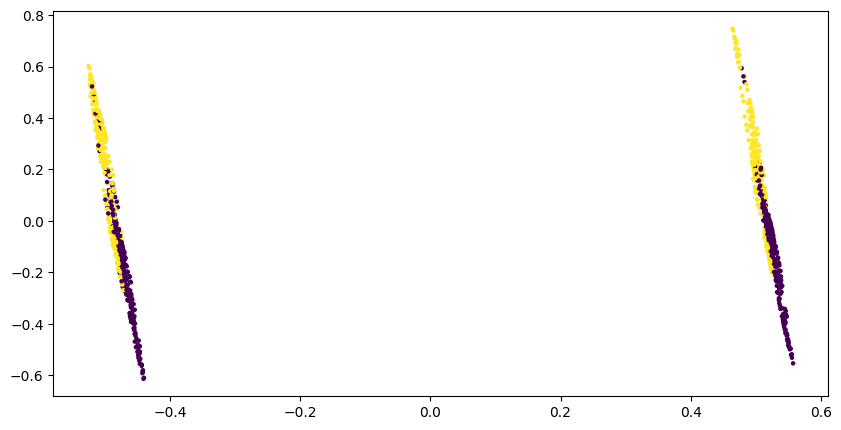

In [11]:
y = dataset['Purchased']
y
plt.figure(figsize=(10,5))
plt.scatter(D2[:, 0], D2[:, 1], s=5, c=y)
plt.show()

С использованием алгоритма t-SNE также проведите для датасета D1 снижение размерности данных до двух. Полученный датасет назовем датасетом D3.

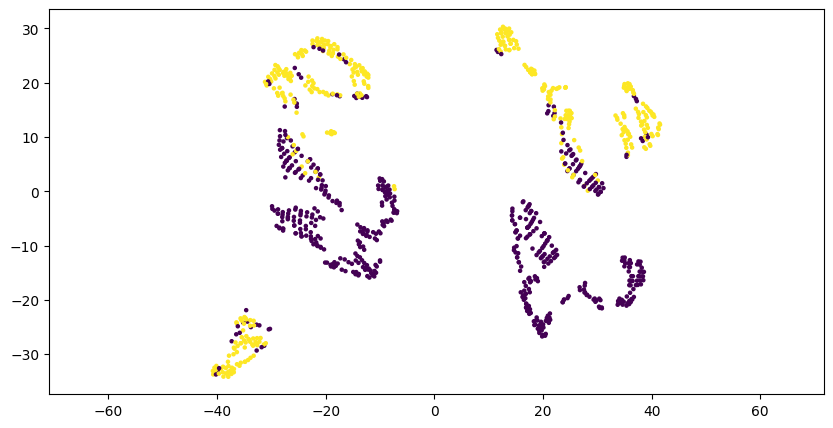

In [12]:
tsne = TSNE(n_components=2, random_state=16)
D3 = tsne.fit_transform(D1)
plt.figure(figsize=(10,5))
plt.scatter(D3[:, 0], D3[:, 1], s=5, c=y)
plt.axis('equal')
plt.show()


оценим качество кластеризации

метод k-средних

In [13]:
def do_clustering(cluster_datasets, method):
    """
    Выполнение кластеризации для данных примера
    """
    cluster_results = []
    for X in cluster_datasets:
        temp_cluster = method.fit_predict(X)
        cluster_results.append(temp_cluster)
    return cluster_results

In [14]:
cluster_datasets = [D2, D3]
cluster_datasetD1 = [D1]
datasets_names = ['D1', 'D2', 'D3']

In [15]:
def visualize_clusters(cluster_datasets, cluster_results, plot_num_start=0):
    """
    Визуализация результатов кластерного анализа
    """
    plt.subplots(figsize=(16,8))
    plot_num = plot_num_start
    for X, y_pred in zip(cluster_datasets, cluster_results):
        plot_num += 1
        plt.subplot(2, 3, plot_num)
        # Цвета точек как результат кластеризации
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # черный цвет для выделяющихся значений
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=3, color=colors[y_pred])
#         plt.xlim(-2.5, 2.5)
#         plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.title(datasets_names[plot_num-1])
    
    plt.show()

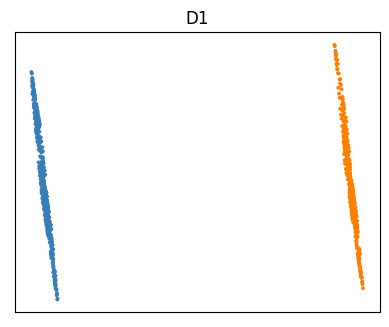

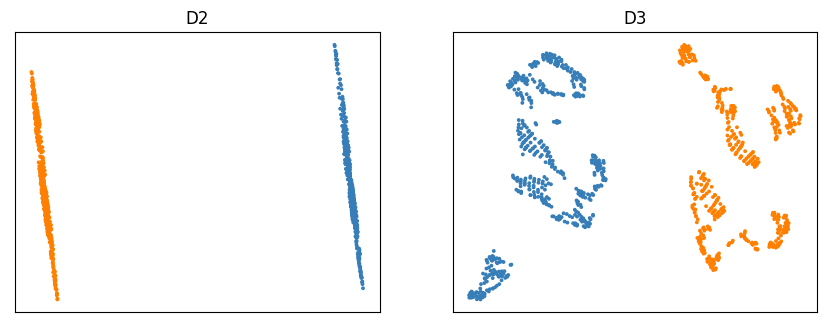

In [16]:
result_KMeans1 = do_clustering(cluster_datasetD1, KMeans(n_clusters=2))
result_KMeans23 = do_clustering(cluster_datasets, KMeans(n_clusters=2))
visualize_clusters(cluster_datasets, result_KMeans1)
visualize_clusters(cluster_datasets, result_KMeans23, plot_num_start=1)

In [17]:
print('Adjusted rand score:')
print('D1: ', adjusted_rand_score(y, result_KMeans1[0]))
print('D2: ', adjusted_rand_score(y, result_KMeans23[0]))
print('D3: ', adjusted_rand_score(y, result_KMeans23[1]))

Adjusted rand score:
D1:  0.0005997013575359381
D2:  0.0005997013575359381
D3:  0.0005997013575359381


In [18]:
# Homogeneity - каждый кластер содержит только представителей единственного класса (под классом понимается истинное значение метки кластера). Значение в диапазоне [0;1], 1 говорит об очень хорошем качестве кластеризации.
# Completeness - все элементы одного класса помещены в один и тот же кластер. Значение в диапазоне [0;1], 1 говорит об очень хорошем качестве кластеризации.
# V-measure - среднее гармоническое от Homogeneity и Completeness.
h1, c1, v1 = homogeneity_completeness_v_measure(y, result_KMeans1[0])
h2, c2, v2 = homogeneity_completeness_v_measure(y, result_KMeans23[0])
h3, c3, v3 = homogeneity_completeness_v_measure(y, result_KMeans23[1])
print('Homogenity:')
print('D1: ', h1)
print('D2: ', h2)
print('D3: ', h3)
print('Completeness:')
print('D1: ', c1)
print('D2: ', c2)
print('D3: ', c3)
print('V-measure:')
print('D1: ', v1)
print('D2: ', v2)
print('D3: ', v3)

Homogenity:
D1:  0.0016553409763421557
D2:  0.0016553409763421557
D3:  0.0016553409763421557
Completeness:
D1:  0.0016103607514635684
D2:  0.0016103607514635684
D3:  0.0016103607514635684
V-measure:
D1:  0.0016325410957735652
D2:  0.0016325410957735652
D3:  0.0016325410957735652


оценка методом Гауса

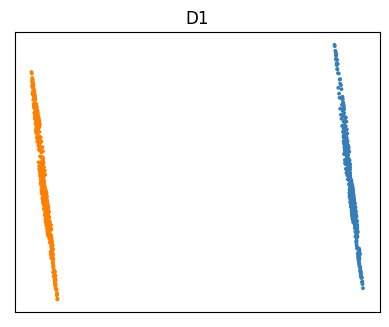

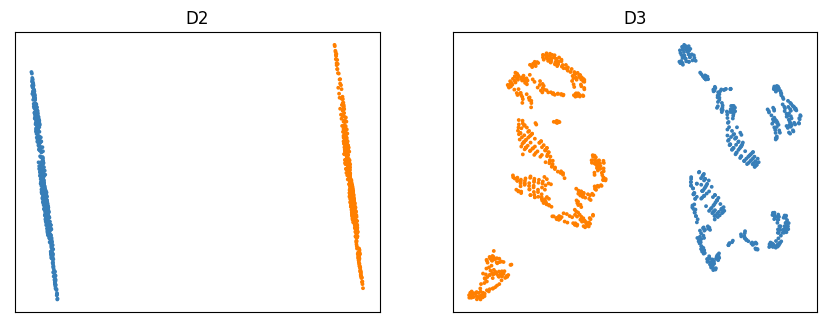

In [19]:
result_GaussianMixture1 = do_clustering(cluster_datasetD1, GaussianMixture(n_components=2))
result_GaussianMixture23 = do_clustering(cluster_datasets, GaussianMixture(n_components=2))

visualize_clusters(cluster_datasets, result_GaussianMixture1)
visualize_clusters(cluster_datasets, result_GaussianMixture23, plot_num_start=1)

In [20]:
print('Adjusted rand score:')
print('D1: ', adjusted_rand_score(y, result_GaussianMixture1[0]))
print('D2: ', adjusted_rand_score(y, result_GaussianMixture23[0]))
print('D3: ', adjusted_rand_score(y, result_GaussianMixture23[1]))

Adjusted rand score:
D1:  0.0005997013575359381
D2:  0.0005997013575359381
D3:  0.0005997013575359381


In [21]:
h1, c1, v1 = homogeneity_completeness_v_measure(y, result_GaussianMixture1[0])
h2, c2, v2 = homogeneity_completeness_v_measure(y, result_GaussianMixture23[0])
h3, c3, v3 = homogeneity_completeness_v_measure(y, result_GaussianMixture23[1])
print('Homogenity:')
print('D1: ', h1)
print('D2: ', h2)
print('D3: ', h3)
print('Completeness:')
print('D1: ', c1)
print('D2: ', c2)
print('D3: ', c3)
print('V-measure:')
print('D1: ', v1)
print('D2: ', v2)
print('D3: ', v3)

Homogenity:
D1:  0.0016553409763421557
D2:  0.0016553409763421557
D3:  0.0016553409763421557
Completeness:
D1:  0.0016103607514635684
D2:  0.0016103607514635684
D3:  0.0016103607514635684
V-measure:
D1:  0.0016325410957735652
D2:  0.0016325410957735652
D3:  0.0016325410957735652


Оценка по Birch

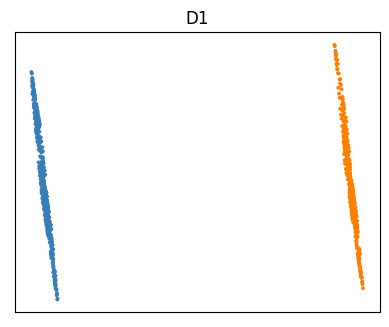

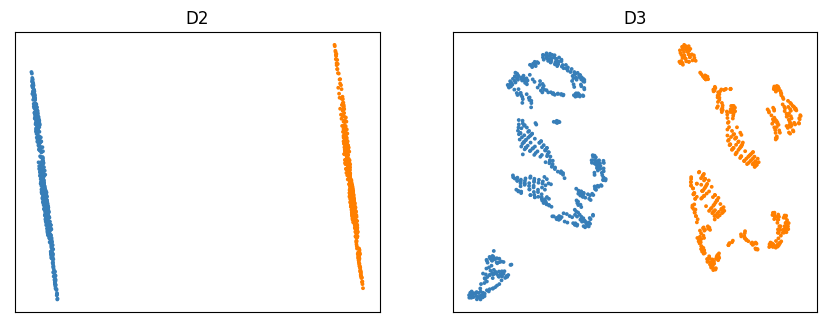

In [22]:
result_Birch1 = do_clustering(cluster_datasetD1, Birch(n_clusters=2))
result_Birch23 = do_clustering(cluster_datasets, Birch(n_clusters=2))

visualize_clusters(cluster_datasets, result_Birch1)
visualize_clusters(cluster_datasets, result_Birch23, plot_num_start=1)

In [23]:
print('Adjusted rand score:')
print('D1: ', adjusted_rand_score(y, result_Birch1[0]))
print('D2: ', adjusted_rand_score(y, result_Birch23[0]))
print('D3: ', adjusted_rand_score(y, result_Birch23[1]))

Adjusted rand score:
D1:  0.0005997013575359381
D2:  0.0005997013575359381
D3:  0.0005997013575359381


In [24]:
h1, c1, v1 = homogeneity_completeness_v_measure(y, result_Birch1[0])
h2, c2, v2 = homogeneity_completeness_v_measure(y, result_Birch23[0])
h3, c3, v3 = homogeneity_completeness_v_measure(y, result_Birch23[1])
print('Homogenity:')
print('D1: ', h1)
print('D2: ', h2)
print('D3: ', h3)
print('Completeness:')
print('D1: ', c1)
print('D2: ', c2)
print('D3: ', c3)
print('V-measure:')
print('D1: ', v1)
print('D2: ', v2)
print('D3: ', v3)

Homogenity:
D1:  0.0016553409763421557
D2:  0.0016553409763421557
D3:  0.0016553409763421557
Completeness:
D1:  0.0016103607514635684
D2:  0.0016103607514635684
D3:  0.0016103607514635684
V-measure:
D1:  0.0016325410957735652
D2:  0.0016325410957735652
D3:  0.0016325410957735652
